In [1]:
! pip install hnsqlite

In [1]:
import json
import os
from openai import OpenAI
from dotenv import load_dotenv
from hnsqlite import Collection
import numpy as np
from numpy import dot
from numpy.linalg import norm
import tiktoken

load_dotenv()

key = os.getenv("API_KEYH")

In [4]:
skills_collection = Collection(collection_name="skills",dimension=1536)
text_collection = Collection(collection_name="text", dimension=1536)
exp_collection = Collection(collection_name="experience", dimension=1536)
client = OpenAI(api_key=key)

2024-04-04 02:33:17.071 | INFO     | hnsqlite.collection:__init__:213 - using sqlite_filename hnsqlite.sqlite
2024-04-04 02:33:17.072 | INFO     | hnsqlite.collection:__init__:221 - sqlite_filename hnsqlite.sqlite exists; using existing database
2024-04-04 02:33:17.108 | INFO     | hnsqlite.collection:__init__:235 - using existing collection skills found in hnsqlite.sqlite
2024-04-04 02:33:17.110 | INFO     | hnsqlite.collection:load_index:366 - load index for description=None id=1 dim=1536 model=None name='skills' created_at=1712013760.7140818
2024-04-04 02:33:17.116 | INFO     | hnsqlite.collection:load_index:372 - loading index filename='index_skills.hnsw' id=5 count=97 M=16 ef_construction=200 created_at=1712013812.5235045 collection_id=1 md5sum='3341bb7583c1b742b662d4c187278677' ef=200 hnsw_ix=None
2024-04-04 02:33:17.130 | INFO     | hnsqlite.collection:load_index:383 - md5sum matches index.md5sum
2024-04-04 02:33:17.136 | INFO     | hnsqlite.collection:load_index:388 - load hnsw

In [11]:
with open("./hrflow-profiles.json","r", encoding="utf8") as j:
    data = json.loads(j.read())

In [4]:
data[0].keys()

dict_keys(['source_key', 'id', 'key', 'reference', 'consent_algorithmic', 'source', 'archive', 'archived_at', 'updated_at', 'created_at', 'info', 'text_language', 'text', 'experiences_duration', 'educations_duration', 'experiences', 'educations', 'attachments', 'skills', 'languages', 'certifications', 'courses', 'tasks', 'interests', 'labels', 'tags', 'metadatas'])

In [6]:
exp_embeddings = {'text':[],'id':[],'vector':[]}
skills_embeddings = {'text':[],'id':[],'vector':[]}
text_embeddings = {'text':[],'id':[],'vector':[]}

for i in range(len(data)):
    for j in range(len(data[i]['experiences'])):
        exp_embeddings['text'].append(data[i]['experiences'][j]['description'])
        exp_embeddings['id'].append(i)
    skills_embeddings['text'].append(', '.join([j['name'] for j in data[i]['skills']]))
    skills_embeddings['id'].append(i)
    text_embeddings['text'].append(data[i]['text'])
    text_embeddings['id'].append(i)
        

In [7]:
exp_embed = client.embeddings.create(input=exp_embeddings['text'], model="text-embedding-3-small")

In [8]:
skills_embed = client.embeddings.create(input=skills_embeddings['text'], model="text-embedding-3-small")

In [9]:
text_embed = client.embeddings.create(input=text_embeddings['text'], model="text-embedding-3-small")

In [10]:
exp_embeddings['vector'] = []
skills_embeddings['vector'] = []
text_embeddings['vector'] = []
for i in range(len(exp_embed.data)):
    exp_embeddings['vector'].append(np.array(exp_embed.data[i].embedding))

for i in range(len(skills_embed.data)):
    skills_embeddings['vector'].append(np.array(skills_embed.data[i].embedding))

for i in range(len(text_embed.data)):
    text_embeddings['vector'].append(np.array(text_embed.data[i].embedding))

In [11]:
exp_collection.add_items(exp_embeddings['vector'], exp_embeddings['text'], exp_embeddings['id'])
skills_collection.add_items(skills_embeddings['vector'], skills_embeddings['text'], skills_embeddings['id'])
text_collection.add_items(text_embeddings['vector'], text_embeddings['text'], text_embeddings['id'])

2024-04-01 16:23:32.443 | INFO     | hnsqlite.collection:_save_index_to_disk:268 - saved index to index_experience.hnsw with md5sum 5011891b900703898400075c40dd640a and 271 items
2024-04-01 16:23:32.453 | INFO     | hnsqlite.collection:_save_index_to_db:283 - saved index to database with id 4
2024-04-01 16:23:32.521 | INFO     | hnsqlite.collection:_save_index_to_disk:268 - saved index to index_skills.hnsw with md5sum 3341bb7583c1b742b662d4c187278677 and 97 items
2024-04-01 16:23:32.531 | INFO     | hnsqlite.collection:_save_index_to_db:283 - saved index to database with id 5
2024-04-01 16:23:32.661 | INFO     | hnsqlite.collection:_save_index_to_disk:268 - saved index to index_text.hnsw with md5sum 7e1459285ff306e2287523a53a60efe3 and 97 items
2024-04-01 16:23:32.669 | INFO     | hnsqlite.collection:_save_index_to_db:283 - saved index to database with id 6


In [4]:
text_collection.count(), skills_collection.count(), exp_collection.count()

(97, 97, 271)

In [5]:
resume = data[0]
exps = [resume['experiences'][i]['description'] for i in range(len(resume['experiences']))]
skills = [', '.join([i['name'] for i in resume['skills']])]
text = [resume['text']]

embeddings = client.embeddings.create(input=exps+skills+text, model="text-embedding-3-small")


In [6]:
embeddings = [np.array(embed.embedding) for embed in embeddings.data]

In [7]:
text_collection.search(embeddings[-1], k=5)

[SearchResponse(id=369, vector=[-0.005217758007347584, -0.023814210668206215, 0.01912393979728222, -0.0014934279024600983, -0.005654531065374613, -0.006638950668275356, -0.0008462477708235383, -0.006988368928432465, -0.03722650185227394, 0.0076872059144079685, 0.03225401043891907, -0.0033513931557536125, -0.022362779825925827, -0.003045652061700821, 0.04808535426855087, 0.05542314052581787, -0.030668187886476517, -0.005933394189924002, -0.02007812075316906, 0.026058552786707878, 0.005849399138242006, -0.004004872869700193, 0.039054229855537415, -0.0014127928297966719, 0.01003234088420868, -0.049267999827861786, -0.029781203716993332, 0.0410163514316082, -0.031904593110084534, -0.01351308636367321, 0.030130621045827866, -0.022322462871670723, -0.010549749247729778, 0.009172233752906322, -0.018236955627799034, -0.015750708058476448, 0.02577633038163185, -0.029404906556010246, 0.038892962038517, 0.01356012374162674, -0.009105037897825241, -0.043059103190898895, 0.008506995625793934, 0.023

In [17]:
def query():
    with open("jd.txt", "r") as f:
        jd = f.read()
    prompt = """extract skills required, summary on about the company, and job responsibilities for the following
    job description in form of python dictionary with "skills_required", "summary", "job_responsibilities" words as respective keywords. return only dictionary and nothing else.

    {jd}""".format(jd=jd)

    res = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[{"role":"system", "content":"you are a resume reviewer helping students get their desired job"},
                {"role":"user", "content":prompt}]
    )

    print(res.choices[0].message.content)

    et = "d="+res.choices[0].message.content

    exec(et, globals())

    jde = client.embeddings.create(input=[jd, ', '.join(d["skills_required"]), d["summary"], '\n'.join(d["job_responsibilities"])], model="text-embedding-3-small")
    jde = [np.array(i.embedding) for i in jde.data]

    text_ids = [i.doc_id for i in text_collection.search(jde[0], k=5)]
    skills_ids = [i.doc_id for i in skills_collection.search(jde[1], k=5)]
    exp_ids = [i.doc_id for i in exp_collection.search(jde[3], k=5)]

    sd = {}
    for i in range(len(text_ids)):
        if text_ids[i] not in sd.keys():
            sd[text_ids[i]] = 5-i
        else:
            sd[text_ids[i]] = sd[text_ids[i]] + (5-i)
        if skills_ids[i] not in sd.keys():
            sd[skills_ids[i]] = 5-i
        else:
            sd[skills_ids[i]] = sd[skills_ids[i]] + (5-i)
        if exp_ids[i] not in sd.keys():
            sd[exp_ids[i]] = 5-i
        else:
            sd[exp_ids[i]] = sd[exp_ids[i]] + (5-i)
    

    r = int(list({k:v for k,v in sorted(sd.items(), key=lambda i:i[1], reverse=True)}.keys())[0])
    print(r)

    with open("./test_resume.json","r", encoding="utf8") as j:
        test_data = json.loads(j.read())
    
    candidate_resume = test_data[0]["text"]
    success_resume = data[r]["text"]

    prompt = """extract action keywords and impact keywords from the following two resume and job description seperately.
    Return the result as a dictionary with resume1_action_keywords, resume2_action_keywords, jd_action_keywords,
    resume1_impact_keywords, resume2_impact_keywords, jd_impact_keywords as keys and the results as values. return only dictionary and nothing else.

    Resume1
    {candidate_resume}

    Resume2
    {success_resume}

    job description
    {jd}

    """.format(candidate_resume = candidate_resume, success_resume = success_resume, jd = jd)
    k = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[{"role":"system", "content":"you are a resume reviewer helping students get their desired job"},
                {"role":"user", "content":prompt}]
                )
    
    et = "resd="+k.choices[0].message.content
    exec(et, globals())

    sskills = [i["name"].lower() for i in data[r]["skills"]]
    cskills = [i["name"].lower() for i in test_data[0]["skills"]]
    jd_skills = [i.lower() for i in d["skills_required"]]
    sact = [i.lower() for i in resd["resume2_action_keywords"]]
    cact = [i.lower() for i in resd["resume1_action_keywords"]]
    jact = [i.lower() for i in resd["jd_action_keywords"]]
    simpact = [i.lower() for i in resd["resume2_impact_keywords"]]
    cimpact = [i.lower() for i in resd["resume1_impact_keywords"]]
    jdimpact = [i.lower() for i in resd["jd_impact_keywords"]]

    skill_score = 0
    for i in cskills:
        if i in sskills and i in jd_skills:
            skill_score = skill_score + 3
        elif i in sskills and i not in jd_skills:
            skill_score = skill_score + 1
        elif i not in sskills and i in jd_skills:
            skill_score = skill_score + 5
    
    
    ai_embeddings = client.embeddings.create(input = [', '.join(cact),
                                                  ', '.join(jact),
                                                  ', '.join(cimpact),
                                                  ', '.join(jdimpact)], model = "text-embedding-3-small")
    
    
    ai_embeddings = [np.array(i.embedding) for i in ai_embeddings.data]

    cembeddings = []
    cembed = client.embeddings.create(input=[i["description"] for i in test_data[0]["experiences"]], model="text-embedding-3-small")
    cembeddings = [np.array(i.embedding) for i in cembed.data]

    def cosine(a,b):
        return dot(a, b)/(norm(a)*norm(b))
    jr_score = 0
    js_score = 0
    for i in cembeddings:
        jr_score = jr_score + cosine(i, jde[3])
        js_score = js_score + cosine(i, jde[2])
    jr_score = jr_score/len(cembeddings)
    js_score = js_score/len(cembeddings)

    jr_score = ((jr_score+1)/2)*100
    js_score = ((js_score+1)/2)*100
    action_score = (cosine(ai_embeddings[0], ai_embeddings[1])+1)*50
    impact_score = (cosine(ai_embeddings[2], ai_embeddings[3])+1)*50

    return [skill_score, action_score, impact_score, jr_score, js_score]

print(query())
    
    

{
    "skills_required": ["JavaScript", "TypeScript", "Angular 2", "HTML", "CSS", "NodeJS", "Swift", "AKS", "NoSQL Database/MongoDB", "Web Programming", "cross-browser compatibility", "Web User Interface Design", "Object-Oriented Design", "API's", "Bootstrap", "Monitoring Tools", "Graph QL", "Automated Testing"],
    "summary": "Our client in Tulsa, Oklahoma is looking for a Web/Mobile Developer to join their team. The role involves designing, coding, and modifying websites and mobile applications to create visually appealing sites with user-friendly design and clear navigation.",
    "job_responsibilities": ["Interact regularly with business stakeholders and management", "Possess strong understanding of UI, cross-browser compatibility, and general web functions and standards", "Plan and deliver software platforms used across multiple products and organizational units", "Work with web development technologies and Single Page Application frameworks", "Develop Mobile Apps and Web APIs us

In [14]:
exec("e="+"""{
    "skills_required": ["JavaScript", "Typescript", "Angular 2", "HTML", "CSS", "Web Programming", "NodeJS", "Swift", "AKS", "NoSQL Database/MongoDB", "cross-browser compatibility", "Web User Interface Design", "Object-Oriented Design", "API's", "Bootstrap", "Monitoring Tools", "Graph QL", "Automated Testing"],
    "summary": "Our client in Tulsa, Oklahoma is looking for a Web/Mobile Developer to design, code, and modify websites and mobile applications to create visually appealing and user-friendly experiences.",
    "job_responsibilities": ["Interact regularly with business stakeholders and management", "Possess strong understanding of UI, cross-browser compatibility, and general web functions and standards", "Plan and deliver software platforms used across multiple products and organizational units", "Work with web development technologies and Single Page Application frameworks", "Develop Mobile Apps and Web APIs using NodeJS", "Practice Continuous Integration and Continuous Deployment when configuring build order and releases", "Implement test-driven development as a daily practice", "Remain up to date with coding terminology, concepts, and best practices", "Work as part of a team or individually on a project", "Participate in Agile Ceremonies"]
}""")

In [15]:
e

{'skills_required': ['JavaScript',
  'Typescript',
  'Angular 2',
  'HTML',
  'CSS',
  'Web Programming',
  'NodeJS',
  'Swift',
  'AKS',
  'NoSQL Database/MongoDB',
  'cross-browser compatibility',
  'Web User Interface Design',
  'Object-Oriented Design',
  "API's",
  'Bootstrap',
  'Monitoring Tools',
  'Graph QL',
  'Automated Testing'],
 'summary': 'Our client in Tulsa, Oklahoma is looking for a Web/Mobile Developer to design, code, and modify websites and mobile applications to create visually appealing and user-friendly experiences.',
 'job_responsibilities': ['Interact regularly with business stakeholders and management',
  'Possess strong understanding of UI, cross-browser compatibility, and general web functions and standards',
  'Plan and deliver software platforms used across multiple products and organizational units',
  'Work with web development technologies and Single Page Application frameworks',
  'Develop Mobile Apps and Web APIs using NodeJS',
  'Practice Continuous

In [12]:
with open("jd.txt", "r") as f:
    jd = f.read()
prompt = """extract skills required, summary on about the company, and job responsibilities for the following
job description in form of python dictionary with "skills_required", "summary", "job_responsibilities" words as respective keywords

{jd}""".format(jd=jd)

res = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[{"role":"system", "content":"you are a resume reviewer helping students get their desired job"},
              {"role":"user", "content":prompt}]
)

In [48]:
exec("d="+res.choices[0].message.content)

In [15]:
d['job_responsibilities']

['Interact regularly with business stakeholders and management',
 'Possess strong understanding of UI, cross-browser compatibility, and general web functions and standards',
 'Plan and deliver software platforms used across multiple products and organizational units',
 'Work with web development technologies and Single Page Application frameworks',
 'Develop Mobile Apps and Web APIs using NodeJS',
 'Practice Continuous Integration and Continuous Deployment when configuring build order and releases',
 'Implement test-driven development as a daily practice',
 'Remain up to date with the terminology, concepts, and best practices for coding',
 'Work as part of a team or individually on a project',
 'Participate in Agile Ceremonies']

In [49]:
jde = client.embeddings.create(input=[jd, ', '.join(d["skills_required"]), d["summary"], '\n'.join(d["job_responsibilities"])], model="text-embedding-3-small")
jde = [np.array(i.embedding) for i in jde.data]

In [50]:
d

{'skills_required': ['JavaScript',
  'Typescript',
  'Angular 2',
  'HTML',
  'CSS',
  'Web Programming',
  'NodeJS',
  'Swift',
  'AKS',
  'NoSQL Database/MongoDB',
  'Cross-browser Compatibility',
  'Web User Interface Design',
  'Object-Oriented Design',
  "API's",
  'Bootstrap',
  'Monitoring Tools',
  'Graph QL',
  'Automated Testing'],
 'summary': 'Our client in Tulsa, Oklahoma is looking for a Web/Mobile Developer to join their team. The role involves designing, coding, and modifying websites and mobile applications according to client specifications, with a focus on user-friendly design and clear navigation.',
 'job_responsibilities': ['Interact regularly with business stakeholders and management',
  'Possess strong understanding of UI, cross-browser compatibility, and general web functions and standards',
  'Plan and deliver software platforms used across multiple products and organizational units',
  'Work with web development technologies and Single Page Application framewor

In [17]:
text_ids = [i.doc_id for i in text_collection.search(jde[0], k=5)]
skills_ids = [i.doc_id for i in skills_collection.search(jde[1], k=5)]
exp_ids = [i.doc_id for i in exp_collection.search(jde[3], k=5)]

In [43]:
sd = {}
for i in range(len(text_ids)):
    if text_ids[i] not in sd.keys():
        sd[text_ids[i]] = 5-i
    else:
        sd[text_ids[i]] = sd[text_ids[i]] + (5-i)
    if skills_ids[i] not in sd.keys():
        sd[skills_ids[i]] = 5-i
    else:
        sd[skills_ids[i]] = sd[skills_ids[i]] + (5-i)
    if exp_ids[i] not in sd.keys():
        sd[exp_ids[i]] = 5-i
    else:
        sd[exp_ids[i]] = sd[exp_ids[i]] + (5-i)

r = int(list({k:v for k,v in sorted(sd.items(), key=lambda i:i[1], reverse=True)}.keys())[0])

In [44]:
r

85

In [ ]:
with open("./test_resume.json","r", encoding="utf8") as j:
    test_data = json.loads(j.read())
test_data[0]

In [20]:
candidate_resume = test_data[0]["text"]
success_resume = data[r]["text"]

In [21]:
prompt = """extract action keywords and impact keywords from the following two resume and job description seperately.
Return the result as a dictionary with resume1_action_keywords, resume2_action_keywords, jd_action_keywords,
resume1_impact_keywords, resume2_impact_keywords, jd_impact_keywords as keys and the results as values.

Resume1
{candidate_resume}

Resume2
{success_resume}

job description
{jd}

""".format(candidate_resume = candidate_resume, success_resume = success_resume, jd = jd)
k = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[{"role":"system", "content":"you are a resume reviewer helping students get their desired job"},
              {"role":"user", "content":prompt}]
              )

In [22]:
exec("resd="+k.choices[0].message.content)

In [23]:
sskills = [i["name"].lower() for i in data[r]["skills"]]
cskills = [i["name"].lower() for i in test_data[0]["skills"]]
jd_skills = [i.lower() for i in d["skills_required"]]
sact = [i.lower() for i in resd["resume2_action_keywords"]]
cact = [i.lower() for i in resd["resume1_action_keywords"]]
jact = [i.lower() for i in resd["jd_action_keywords"]]
simpact = [i.lower() for i in resd["resume2_impact_keywords"]]
cimpact = [i.lower() for i in resd["resume1_impact_keywords"]]
jdimpact = [i.lower() for i in resd["jd_impact_keywords"]]

In [24]:
skill_score = 0
for i in cskills:
    if i in sskills and i in jd_skills:
        skill_score = skill_score + 3
    elif i in sskills and i not in jd_skills:
        skill_score = skill_score + 1
    elif i not in sskills and i in jd_skills:
        skill_score = skill_score + 5
act_score = 0
for i in cact:
    if i in sact and i in jact:
        act_score = act_score + 3
    elif i in sact and i not in jact:
        act_score = act_score + 1
    elif i not in sact and i in jact:
        act_score = act_score + 5
imp_score = 0
for i in cimpact:
    if i in simpact and i in jdimpact:
        imp_score = imp_score + 3
    elif i in simpact and i not in jdimpact:
        imp_score = imp_score + 1
    elif i not in simpact and i in jdimpact:
        imp_score = imp_score + 5

In [30]:
skill_score = (skill_score/(5*len(cskills)))*100
act_score = (act_score/(5*len(cact)))*100
imp_score = (imp_score/(5*len(cimpact)))*100

In [32]:
ai_embeddings = client.embeddings.create(input = [', '.join(cact),
                                                  ', '.join(jact),
                                                  ', '.join(cimpact),
                                                  ', '.join(jdimpact)], model = "text-embedding-3-small")

In [33]:
ai_embeddings = [np.array(i.embedding) for i in ai_embeddings.data]

In [25]:
cembeddings = []
cembed = client.embeddings.create(input=[i["description"] for i in test_data[0]["experiences"]], model="text-embedding-3-small")
cembeddings = [np.array(i.embedding) for i in cembed.data]
cembeddings

[array([-0.02413737,  0.01014867, -0.03369828, ..., -0.00701394,
         0.0027837 ,  0.01098459]),
 array([-0.03450317, -0.02814301,  0.03777878, ..., -0.02912569,
        -0.00575963,  0.00396486])]

In [26]:
sembeddings = [i.vector for i in text_collection.get_embeddings_doc_ids([r])]

In [34]:
def cosine(a,b):
    return dot(a, b)/(norm(a)*norm(b))
jr_score = 0
js_score = 0
for i in cembeddings:
    jr_score = jr_score + cosine(i, jde[3])
    js_score = js_score + cosine(i, jde[2])
jr_score = jr_score/len(cembeddings)
js_score = js_score/len(cembeddings)

jr_score = ((jr_score+1)/2)*100
js_score = ((js_score+1)/2)*100
action_score = (cosine(ai_embeddings[0], ai_embeddings[1])+1)*50
impact_score = (cosine(ai_embeddings[2], ai_embeddings[3])+1)*50


In [38]:
[skill_score, action_score, impact_score, jr_score, js_score]

[3.4782608695652173,
 76.59060936610516,
 75.59307104247104,
 69.02663978818158,
 63.232263711623695]

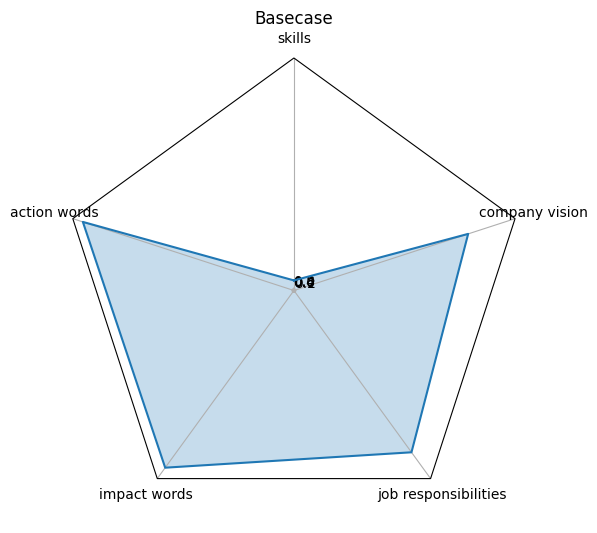

array([-0.0485617 ,  0.01621111,  0.02896035, ...,  0.00663128,
       -0.01457567, -0.00107139])

In [31]:
data[0]['experiences'][0]['description'], ', '.join([j['name'] for j in data[0]['skills']]), data[0]['text']

('Software Engineer, Raven Industries\nScottsdale, AZ\nInitially I worked on an electron app where I created features to remotely download,\nanalyze, and collect log files using node, typescript, and react. I quickly advanced\nto lead on an applications project that would run in an embedded environment\nusing C++ and python. During this project I gained experience in Open Embedded,\nYocto, and Bitbake. My most recent project is a simulation tool that I spearheaded\nthe development and is being used to test the systems in a virtual environment\nusing websockets and unity.\n• Created and updated documentation for designs, all phases of the project',
 'arduino, bash, bitbake, c, c#, c++, cse310hw07, css, ejs, html, java, javascript, linux, mongodb, mqtt, mvvm, node, open embedded, openembedded, postage sql, postgres, python, react, sql, typescript, unity, websockets, xamarin, yocto',
 'NATHANIEL RICKERTSEN\n\nDETAILS\n\nPHONE\n\nEMAIL\n\nSKILLS\n\nProgramming & Data\nStructure\n\nPython\n

In [9]:
prompt = "return a python dictionary. only dictionary and nothin else"
k = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[{"role":"system", "content":"you are a resume reviewer helping students get their desired job"},
              {"role":"user", "content":prompt}]
              )

In [10]:
k.choices[0].message.content

'{\n    "Name": "John Doe",\n    "Title": "Software Engineer",\n    "Experience": "3 years",\n    "Skills": ["Python", "Java", "SQL"],\n    "Education": "Bachelor\'s degree in Computer Science",\n    "Certifications": ["AWS Certified Developer", "Google Professional Cloud Architect"],\n    "Languages": ["English", "Spanish"]\n}'